# GA Evaluation Across Weather Scenarios

This notebook:
1. Generates 20 synthetic weather scenarios (normal to extreme)
2. Runs GA optimization on the baseline (historical) weather to find the optimal fixed strategy
3. Evaluates that fixed strategy on all 20 scenarios
4. Saves results for comparison with MPC

In [19]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import sys
import time

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.ga.ga_bounds import DesignSpaceBounds
from core.ga.ga_params import GeneticAlgorithmParams
from core.ga.ga import GeneticAlgorithm
from core.ga.ga_member import Member
from core.ga.ga_population import Population

from core.model.model_carrying_capacities import ModelCarryingCapacities
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

from core.weather.stochastic_weather import (
    StochasticWeatherGenerator,
    WeatherScenario,
    get_default_scenarios,
    scenarios_to_dataframe
)

from core.plotting.plotting_params import PlottingParams
from core.plotting.plotting_colors import PlottingColors

# Apply plotting style (LaTeX + color-blind friendly)
plotting_params = PlottingParams()
plotting_colors = PlottingColors()
plotting_colors.apply_as_default()

## 1. Generate Weather Scenarios

In [20]:
# Load historical weather data
historical_df = pd.read_csv('../../io/inputs/hourly_prcp_rad_temp_iowa.csv')
print(f"Historical data shape: {historical_df.shape}")
print(f"Columns: {historical_df.columns.tolist()}")

Historical data shape: (2928, 3)
Columns: ['Hourly Precipitation (in)', 'Hourly Radiation (W/m2)', 'Temperature (C)']


In [21]:
# Create weather generator with fixed seed for reproducibility
generator = StochasticWeatherGenerator(historical_df, seed=42)

# Get default scenarios (20 scenarios from normal to extreme)
scenarios = get_default_scenarios()

# Display scenario summary
scenario_summary = scenarios_to_dataframe(scenarios)
print("Weather Scenarios Summary:")
print(scenario_summary.to_string())

Weather Scenarios Summary:
                    name  precip_scale  temp_offset  noise_std  n_drought_events  n_heatwave_events  extremity_index
0               normal_1          1.00          0.0       0.03                 0                  0             0.00
1               normal_2          0.95          0.5       0.03                 0                  0             0.20
2               normal_3          1.05         -0.5       0.03                 0                  0             0.20
3               normal_4          0.90          1.0       0.05                 0                  0             0.40
4               normal_5          1.10         -1.0       0.05                 0                  0             0.40
5           moderate_dry          0.75          1.5       0.05                 0                  0             0.80
6           moderate_wet          1.25         -1.0       0.05                 0                  0             0.70
7          moderate_warm          0.9

In [22]:
# Generate all weather scenarios
weather_data = generator.generate_batch(scenarios)

# Add the original historical as "baseline"
weather_data['baseline'] = historical_df.copy()

print(f"Generated {len(weather_data)} weather scenarios")
for name in weather_data:
    df = weather_data[name]
    print(f"  {name}: precip_total={df['Hourly Precipitation (in)'].sum():.1f} in, "
          f"temp_mean={df['Temperature (C)'].mean():.1f} C")

Generated 21 weather scenarios
  normal_1: precip_total=31.5 in, temp_mean=22.8 C
  normal_2: precip_total=29.9 in, temp_mean=23.3 C
  normal_3: precip_total=33.0 in, temp_mean=22.3 C
  normal_4: precip_total=28.3 in, temp_mean=23.8 C
  normal_5: precip_total=34.6 in, temp_mean=21.8 C
  moderate_dry: precip_total=23.6 in, temp_mean=24.3 C
  moderate_wet: precip_total=39.3 in, temp_mean=21.8 C
  moderate_warm: precip_total=28.3 in, temp_mean=25.3 C
  moderate_cool: precip_total=34.6 in, temp_mean=20.8 C
  moderate_variable: precip_total=31.5 in, temp_mean=22.8 C
  mild_drought: precip_total=17.8 in, temp_mean=23.8 C
  summer_drought: precip_total=21.3 in, temp_mean=24.8 C
  early_drought: precip_total=19.1 in, temp_mean=24.3 C
  late_drought: precip_total=18.1 in, temp_mean=23.8 C
  wet_year: precip_total=44.1 in, temp_mean=21.3 C
  cool_wet: precip_total=40.9 in, temp_mean=20.3 C
  heat_stress: precip_total=25.2 in, temp_mean=25.1 C
  multiple_heatwaves: precip_total=26.7 in, temp_mean

In [23]:
# Save weather scenarios for MPC notebook to use
os.makedirs('weather_scenario_results', exist_ok=True)

with open('weather_scenario_results/weather_scenarios.pkl', 'wb') as f:
    pickle.dump(weather_data, f)

with open('weather_scenario_results/scenario_configs.pkl', 'wb') as f:
    pickle.dump(scenarios, f)

scenario_summary.to_csv('weather_scenario_results/scenario_summary.csv', index=False)
print("Weather scenarios saved.")

Weather scenarios saved.


## 2. Model and GA Parameters

In [24]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 1.0,  # hours/step
    simulation_hours = 2900, # hours
    verbose          = False
)

In [25]:
# Set ModelCarryingCapacities (corn defaults)
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [26]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [27]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [28]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours,
    A0=carrying_capacities.kA/model_params.simulation_hours,
    N0=carrying_capacities.kN/model_params.simulation_hours,
    c0=carrying_capacities.kc/model_params.simulation_hours,
    P0=carrying_capacities.kP/model_params.simulation_hours
)

In [29]:
# Set typical disturbances
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

In [30]:
# Set design space bounds
lower_bounds = np.array([12, 0, 24, 0])      # [irr_freq, irr_amt, fert_freq, fert_amt]
upper_bounds = np.array([2900, 10, 2900, 700])

bounds = DesignSpaceBounds(
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds
)

In [31]:
# GA parameters
ga_params = GeneticAlgorithmParams(
    num_parents     = 16,
    num_kids        = 16,
    num_generations = 100,
    num_members     = 128,
)

## 3. Run GA Optimization on Baseline Weather

Find the optimal *fixed* strategy using the historical (baseline) weather.

In [32]:
# Create disturbances from baseline weather
baseline_weather = weather_data['baseline']
baseline_disturbances = ModelDisturbances(
    precipitation = baseline_weather['Hourly Precipitation (in)'].to_numpy(),
    radiation     = baseline_weather['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = baseline_weather['Temperature (C)'].to_numpy()
)

In [33]:
# Create GeneticAlgorithm object
ga = GeneticAlgorithm(
    bounds               = bounds,
    ga_params            = ga_params,
    model_params         = model_params,
    carrying_capacities  = carrying_capacities,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    disturbances         = baseline_disturbances,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities
)

In [34]:
# Run GA with C++ evaluator for speed
print("Running GA optimization on baseline weather...")
t_start = time.time()

ga_result = ga.run_with_cpp()

t_end = time.time()
print(f"GA optimization completed in {t_end - t_start:.1f} seconds")

Running GA optimization on baseline weather...
Time taken to evaluate population with C++ evaluator: 0.3719961643218994 seconds
Time taken to calculate costs for g=0: 0.37636876106262207 seconds
Generation 2 of 100
Time taken to breed kids for g=1: 0.00012063980102539062 seconds
Time taken to fill random members for g=1: 0.001165151596069336 seconds
Time taken to evaluate population with C++ evaluator: 0.37131810188293457 seconds
Time taken to calculate costs for g=1: 0.37511491775512695 seconds
Lowest cost in generation 1: -868.32
Time taken to sort population for g=1: 3.719329833984375e-05 seconds
Generation 3 of 100
Time taken to breed kids for g=2: 0.00010991096496582031 seconds
Time taken to fill random members for g=2: 0.0009629726409912109 seconds
Time taken to evaluate population with C++ evaluator: 0.37189197540283203 seconds
Time taken to calculate costs for g=2: 0.37581419944763184 seconds
Lowest cost in generation 2: -868.32
Time taken to sort population for g=2: 4.67300415

In [35]:
# Extract optimal fixed strategy
optimal_strategy = ga_result.final_population.values[0]  # best member
optimal_cost = ga_result.final_population.costs[0]

print(f"\nOptimal Fixed Strategy:")
print(f"  Irrigation frequency: {optimal_strategy[0]:.1f} hours (every {optimal_strategy[0]/24:.1f} days)")
print(f"  Irrigation amount:    {optimal_strategy[1]:.2f} inches")
print(f"  Fertilizer frequency: {optimal_strategy[2]:.1f} hours (every {optimal_strategy[2]/24:.1f} days)")
print(f"  Fertilizer amount:    {optimal_strategy[3]:.1f} lbs")
print(f"\nExpected revenue on baseline weather: ${-optimal_cost:.2f}")


Optimal Fixed Strategy:
  Irrigation frequency: 1977.3 hours (every 82.4 days)
  Irrigation amount:    -0.21 inches
  Fertilizer frequency: 99.9 hours (every 4.2 days)
  Fertilizer amount:    13.1 lbs

Expected revenue on baseline weather: $1052.40


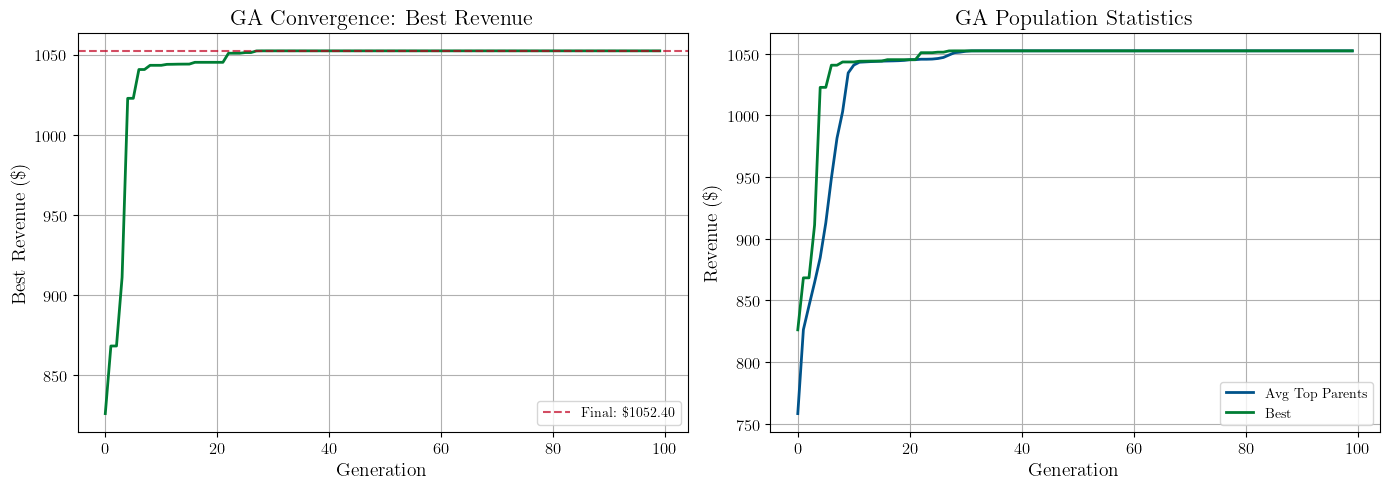

In [36]:
# Plot GA convergence
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Best cost (revenue) over generations
ax1 = axes[0]
generations = range(len(ga_result.lowest_costs))
revenues = [-c for c in ga_result.lowest_costs]  # Convert cost to revenue
ax1.plot(generations, revenues, color=plotting_colors.vivid_green, linewidth=2)
ax1.set_xlabel('Generation')
ax1.set_ylabel('Best Revenue (\\$)')
ax1.set_title('GA Convergence: Best Revenue')
ax1.axhline(revenues[-1], color=plotting_colors.vivid_red, linestyle='--', 
            alpha=0.7, label=f'Final: \\${revenues[-1]:.2f}')
ax1.legend(loc='lower right')

# Right: Best vs Average parent costs
ax2 = axes[1]
avg_revenues = [-c for c in ga_result.avg_parent_costs]
ax2.plot(generations, avg_revenues, color=plotting_colors.strong_blue, 
         linewidth=2, label='Avg Top Parents')
ax2.plot(generations, revenues, color=plotting_colors.vivid_green, 
         linewidth=2, label='Best')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Revenue (\\$)')
ax2.set_title('GA Population Statistics')
ax2.legend()

plt.tight_layout()
plt.savefig('weather_scenario_results/ga_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

In [37]:
# Save optimal strategy
with open('weather_scenario_results/ga_optimal_strategy.pkl', 'wb') as f:
    pickle.dump({
        'strategy': optimal_strategy,
        'baseline_cost': optimal_cost,
        'baseline_revenue': -optimal_cost
    }, f)

print("Optimal strategy saved.")

Optimal strategy saved.


## 4. Evaluate Fixed Strategy on All Weather Scenarios

The GA found one optimal strategy. Now we evaluate how that *fixed* strategy performs across all 20 weather scenarios.

In [38]:
# Evaluate optimal strategy on each weather scenario
ga_results = {}

# Get economic weights
weight_fruit_biomass = ga_params.weight_fruit_biomass
weight_height = ga_params.weight_height
weight_leaf_area = ga_params.weight_leaf_area
weight_irrigation = ga_params.weight_irrigation
weight_fertilizer = ga_params.weight_fertilizer

# Create model params with verbose=True for evaluation (to get state trajectories)
eval_model_params = ModelParams(
    dt               = model_params.dt,
    simulation_hours = model_params.simulation_hours,
    verbose          = True  # Enable CSV output for state trajectories
)

print("Evaluating fixed strategy on all scenarios...\n")

for scenario_name, weather_df in weather_data.items():
    # Create disturbances for this scenario
    scenario_disturbances = ModelDisturbances(
        precipitation = weather_df['Hourly Precipitation (in)'].to_numpy(),
        radiation     = weather_df['Hourly Radiation (W/m2)'].to_numpy(),
        temperature   = weather_df['Temperature (C)'].to_numpy()
    )
    
    # Create member with optimal strategy (using verbose model params)
    member = Member(
        ga_params            = ga_params,
        carrying_capacities  = carrying_capacities,
        disturbances         = scenario_disturbances,
        growth_rates         = growth_rates,
        initial_conditions   = initial_conditions,
        model_params         = eval_model_params,  # Use verbose params
        typical_disturbances = typical_disturbances,
        sensitivities        = sensitivities,
        values               = optimal_strategy
    )
    
    # Evaluate (this writes to output_get_cost.csv when verbose=True)
    cost = member.get_cost()
    revenue = -cost
    
    # Read detailed results from CSV
    output = pd.read_csv('output_get_cost.csv')
    P_final = output['P'].iloc[-1]
    h_final = output['h'].iloc[-1]
    A_final = output['A'].iloc[-1]
    
    # Calculate irrigation and fertilizer totals from strategy
    simulation_hours = model_params.simulation_hours
    n_irrigations = int(simulation_hours / optimal_strategy[0])
    n_fertilizations = int(simulation_hours / optimal_strategy[2])
    total_irrigation = n_irrigations * optimal_strategy[1]
    total_fertilizer = n_fertilizations * optimal_strategy[3]
    
    ga_results[scenario_name] = {
        'revenue': revenue,
        'cost': cost,
        'fruit_biomass': P_final,
        'height': h_final,
        'leaf_area': A_final,
        'total_irrigation': total_irrigation,
        'total_fertilizer': total_fertilizer,
        'precip_total': weather_df['Hourly Precipitation (in)'].sum(),
        'temp_mean': weather_df['Temperature (C)'].mean()
    }
    
    print(f"{scenario_name:25s}: Revenue=${revenue:7.2f}, Fruit={P_final:.3f}kg")

Evaluating fixed strategy on all scenarios...

normal_1                 : Revenue=$1052.60, Fruit=0.236kg
normal_2                 : Revenue=$1062.27, Fruit=0.238kg
normal_3                 : Revenue=$1022.82, Fruit=0.230kg
normal_4                 : Revenue=$1039.97, Fruit=0.233kg
normal_5                 : Revenue=$ 982.17, Fruit=0.222kg
moderate_dry             : Revenue=$ 940.17, Fruit=0.214kg
moderate_wet             : Revenue=$ 919.43, Fruit=0.208kg
moderate_warm            : Revenue=$ 993.60, Fruit=0.226kg
moderate_cool            : Revenue=$ 935.02, Fruit=0.213kg
moderate_variable        : Revenue=$1051.39, Fruit=0.236kg
mild_drought             : Revenue=$ 820.21, Fruit=0.190kg
summer_drought           : Revenue=$ 878.65, Fruit=0.202kg
early_drought            : Revenue=$ 831.19, Fruit=0.192kg
late_drought             : Revenue=$ 862.77, Fruit=0.197kg
wet_year                 : Revenue=$ 813.27, Fruit=0.187kg
cool_wet                 : Revenue=$ 823.49, Fruit=0.190kg
heat_stre

In [39]:
# Convert to DataFrame
ga_results_df = pd.DataFrame(ga_results).T
ga_results_df.index.name = 'scenario'
ga_results_df = ga_results_df.reset_index()

# Add extremity index
scenario_configs = {s.name: s for s in scenarios}
ga_results_df['extremity'] = ga_results_df['scenario'].apply(
    lambda x: scenario_configs[x].extremity_index() if x in scenario_configs else 0.0
)

print("\nGA Results Summary:")
print(ga_results_df.to_string())


GA Results Summary:
                scenario      revenue         cost  fruit_biomass    height  leaf_area  total_irrigation  total_fertilizer  precip_total  temp_mean  extremity
0               normal_1  1052.604468 -1052.604468       0.235992  2.899642   0.617649         -0.205799        378.936629     31.466250  22.817276       0.00
1               normal_2  1062.268915 -1062.268915       0.237833  2.933315   0.619024         -0.205799        378.936629     29.892937  23.322283       0.20
2               normal_3  1022.818033 -1022.818033       0.230227  2.841469   0.607911         -0.205799        378.936629     33.039562  22.321052       0.20
3               normal_4  1039.966672 -1039.966672       0.233432  2.918734   0.608754         -0.205799        378.936629     28.319625  23.836749       0.40
4               normal_5   982.168507  -982.168507       0.221858  2.785044   0.601243         -0.205799        378.936629     34.612875  21.831446       0.40
5           moderate_dry 

In [40]:
# Save GA evaluation results
with open('weather_scenario_results/ga_scenario_results.pkl', 'wb') as f:
    pickle.dump(ga_results, f)

ga_results_df.to_csv('weather_scenario_results/ga_scenario_results.csv', index=False)

print("GA scenario results saved.")

GA scenario results saved.


## 5. Summary Statistics

In [41]:
# Summary statistics
print("GA Fixed Strategy Performance Across Scenarios")
print("=" * 50)
print(f"Mean revenue:   ${ga_results_df['revenue'].mean():.2f}")
print(f"Std revenue:    ${ga_results_df['revenue'].std():.2f}")
print(f"Min revenue:    ${ga_results_df['revenue'].min():.2f} ({ga_results_df.loc[ga_results_df['revenue'].idxmin(), 'scenario']})")
print(f"Max revenue:    ${ga_results_df['revenue'].max():.2f} ({ga_results_df.loc[ga_results_df['revenue'].idxmax(), 'scenario']})")
print(f"\nBaseline revenue: ${ga_results_df[ga_results_df['scenario'] == 'baseline']['revenue'].values[0]:.2f}")

GA Fixed Strategy Performance Across Scenarios
Mean revenue:   $909.93
Std revenue:    $145.69
Min revenue:    $513.89 (worst_case)
Max revenue:    $1062.27 (normal_2)

Baseline revenue: $1053.03


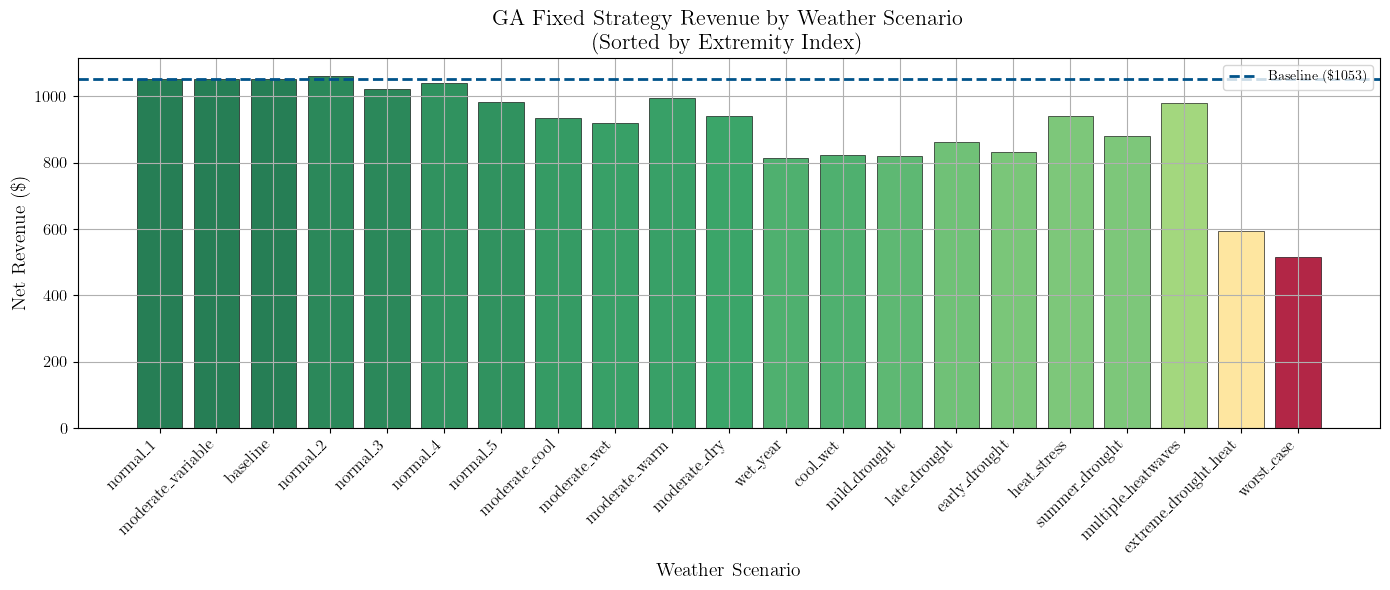

In [42]:
# Plot revenue by scenario
fig, ax = plt.subplots(figsize=(14, 6))

# Sort by extremity for better visualization
df_sorted = ga_results_df.sort_values('extremity')

# Create color gradient based on extremity
max_extremity = df_sorted['extremity'].max()
if max_extremity > 0:
    colors = plt.cm.RdYlGn_r(df_sorted['extremity'] / max_extremity)
else:
    colors = [plotting_colors.vivid_green] * len(df_sorted)

bars = ax.bar(range(len(df_sorted)), df_sorted['revenue'], color=colors,
              alpha=0.85, edgecolor='black', linewidth=0.5)
ax.set_xticks(range(len(df_sorted)))
ax.set_xticklabels(df_sorted['scenario'], rotation=45, ha='right')
ax.set_xlabel('Weather Scenario')
ax.set_ylabel('Net Revenue (\\$)')
ax.set_title('GA Fixed Strategy Revenue by Weather Scenario\n(Sorted by Extremity Index)')

# Get baseline revenue
baseline_rows = ga_results_df[ga_results_df['scenario'] == 'baseline']
if len(baseline_rows) > 0:
    baseline_revenue = baseline_rows['revenue'].values[0]
    ax.axhline(baseline_revenue, color=plotting_colors.strong_blue, 
               linestyle='--', linewidth=2, label=f'Baseline (\\${baseline_revenue:.0f})')
    ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig('weather_scenario_results/ga_revenue_by_scenario.png', dpi=150, bbox_inches='tight')
plt.show()

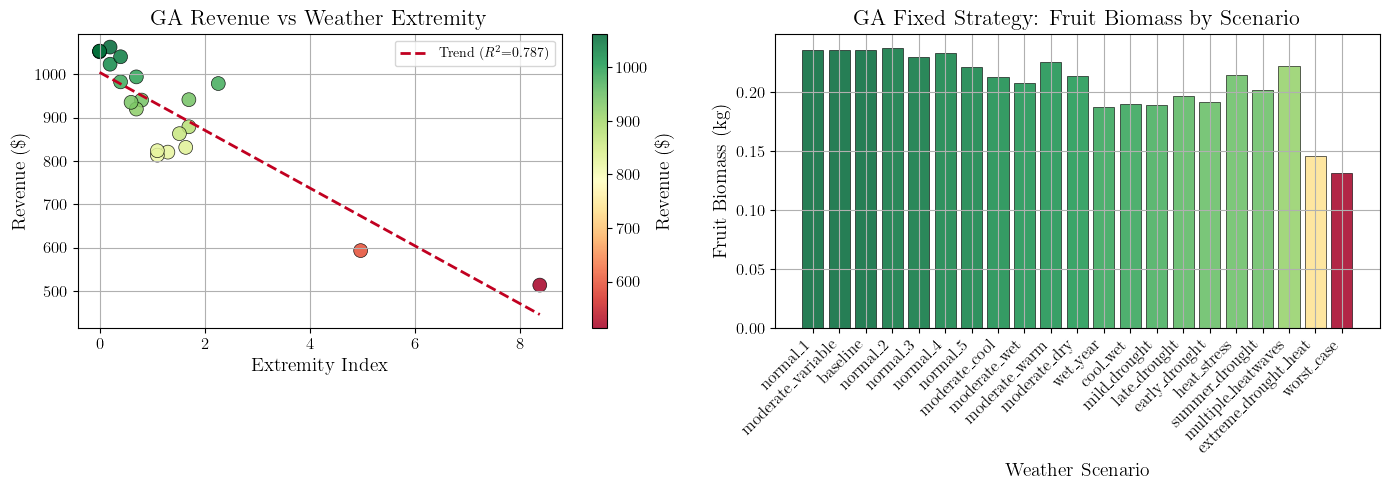


GA Revenue vs Extremity Correlation:
  Pearson R = -0.887
  Slope = \$-66.57 per unit extremity


In [43]:
# Plot revenue vs extremity with trend line
from scipy import stats

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Revenue vs Extremity scatter
ax1 = axes[0]
sc = ax1.scatter(ga_results_df['extremity'], ga_results_df['revenue'], 
                 c=ga_results_df['revenue'], cmap='RdYlGn', s=100,
                 edgecolor='black', linewidth=0.5, alpha=0.85)
plt.colorbar(sc, ax=ax1, label='Revenue (\\$)')

# Add trend line
slope, intercept, r_value, p_value, _ = stats.linregress(
    ga_results_df['extremity'], ga_results_df['revenue'])
x_trend = np.linspace(0, ga_results_df['extremity'].max(), 100)
ax1.plot(x_trend, slope * x_trend + intercept, color=plotting_colors.vivid_red,
         linestyle='--', linewidth=2, label=f'Trend ($R^2$={r_value**2:.3f})')

ax1.set_xlabel('Extremity Index')
ax1.set_ylabel('Revenue (\\$)')
ax1.set_title('GA Revenue vs Weather Extremity')
ax1.legend(loc='upper right')

# Right: Fruit biomass by scenario
ax2 = axes[1]
df_sorted = ga_results_df.sort_values('extremity')
max_extremity = df_sorted['extremity'].max()
if max_extremity > 0:
    colors = plt.cm.RdYlGn_r(df_sorted['extremity'] / max_extremity)
else:
    colors = [plotting_colors.vivid_green] * len(df_sorted)

ax2.bar(range(len(df_sorted)), df_sorted['fruit_biomass'], color=colors,
        alpha=0.85, edgecolor='black', linewidth=0.5)
ax2.set_xticks(range(len(df_sorted)))
ax2.set_xticklabels(df_sorted['scenario'], rotation=45, ha='right')
ax2.set_xlabel('Weather Scenario')
ax2.set_ylabel('Fruit Biomass (kg)')
ax2.set_title('GA Fixed Strategy: Fruit Biomass by Scenario')

plt.tight_layout()
plt.savefig('weather_scenario_results/ga_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGA Revenue vs Extremity Correlation:")
print(f"  Pearson R = {r_value:.3f}")
print(f"  Slope = \\${slope:.2f} per unit extremity")